# Wake County Voter Data

<img src='wakeweb.jpg'>

## Download zipfile from http://www.wakegov.com/elections/data/Pages/data.aspx into the location of the notebook

## Extract The contents of the zipfile ( 3 Excel spreadsheets ) into the same directory, creating vrdb subdirectory

<img src='extract.jpg'>

In [1]:
import pandas as pd
from time import ctime
import matplotlib.pyplot as plt
import numpy as np

## Read the Excel spreadsheets

In [2]:
print(ctime(),"Start read excel")
print(ctime(),"Finish read excel")

Wed Apr 24 00:16:42 2019 Start read excel
Wed Apr 24 00:16:42 2019 Finish read excel


## Since this takes a very long time, create fast pickle files for re-use

In [5]:
#vrdb01.to_pickle('vrdb01.pkl')
#vrdb02_12.to_pickle('vrdb02_12.pkl')
#vrdb13_20.to_pickle('vrdb13_20.pkl')

## Load the pickle files

In [5]:
voter = pd.concat([vrdb01,vrdb02_12,vrdb13_20])

NameError: name 'vrdb01' is not defined

## Search the dataframes to find someone we know

In [6]:
dfs = [vrdb01,vrdb02_12,vrdb13_20]
for i in range(len(dfs)):
    nrecs = ((dfs[i].last_name=='MCFARLANE') & (dfs[i].first_name=='NANCY')).sum()
    print("Found",nrecs,"in dataframe",i)


Found 1 in dataframe 0
Found 0 in dataframe 1
Found 0 in dataframe 2


## Examine the record

In [8]:
df = vrdb01
df[(df.last_name=='MCFARLANE') & (df.first_name=='NANCY')]

,county_name,ReportDate,voter_reg_num,status_lbl,last_name,first_name,middle_name,name_suffix_lbl,house_num,half_code,...,11/04/2014,10/06/2015,11/03/2015,03/15/2016,06/07/2016,11/08/2016,10/10/2017,11/07/2017,05/08/2018,11/06/2018
18564,WAKE,2019-04-08,9937635,A,MCFARLANE,NANCY,LOUISE,NaN,3620,NaN,...,V,V,NaN,V,V,V,O,V,O,O


## Load the Real Estate data

In [9]:
realestate = pd.read_pickle('RealEstateLatLong.pkl')

## Make a small dataframe address and lat, long

In [10]:
latlong = realestate[['Street_Name', 'Street_Number', 'PHYSICAL_ZIP_CODE', 'lat','long']].copy(deep=True)
latlong.columns = ['street_name','house_num','zip','lat','long']
latlong = latlong.dropna()
latlong.zip = latlong.zip.astype(int)

## Merge with the voter data

In [11]:
latlongdedup = latlong.drop_duplicates(subset=['street_name','house_num','zip'])
voterdedup = voter.drop_duplicates(subset=['street_name','house_num','zip'])
latlong.shape, latlongdedup.shape, voter.shape, voterdedup.shape

((573767, 5), (373512, 5), (712489, 63), (302620, 63))

In [12]:
dfboth = pd.merge(latlongdedup, voterdedup, on=['street_name','house_num','zip'])
dfboth.shape

(279496, 65)

## What parties do the voters belong to

In [13]:
dfboth.party_lbl.value_counts()

UNA    102132
DEM    100549
REP     74913
LIB      1801
GRE        52
CST        49
Name: party_lbl, dtype: int64

## Map the party to a color

In [14]:
colorMap = {'DEM':'b',
           'REP':'r',
           'UNA':'y',
           'LIB':'c',
           'GRE':'g',
           'CST':'w'}

In [15]:
colorVec = [colorMap[x]for x in dfboth.party_lbl]

## Plot wake county by voter part affiliation

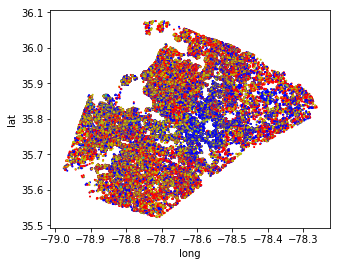

In [17]:
dfboth.plot.scatter(x="long",y="lat",c=colorVec,s=1)
plt.axes().set_aspect('equal')
plt.show()

## Election map of Wake County

From Wake County Board

<img src='wakecounty.png'  alt="Wake" height="300" width="300">

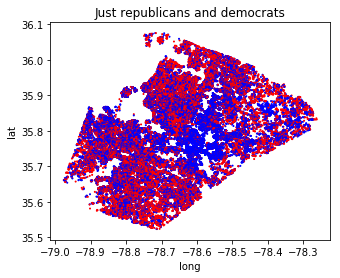

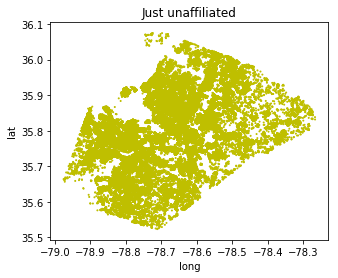

In [18]:
# just republicans or democrats
colorVec = np.array(colorVec)
which = [x in ('REP','DEM') for x in dfboth.party_lbl] 
dfboth[which].plot.scatter(x="long",y="lat",c=colorVec[which],s=1)
plt.axes().set_aspect('equal')
plt.title("Just republicans and democrats")
plt.show()


which = [x in ('UNA') for x in dfboth.party_lbl]
dfboth[which].plot.scatter(x="long",y="lat",c=colorVec[which],s=1)
plt.axes().set_aspect('equal')
plt.title("Just unaffiliated")
plt.show()


In [22]:
# ! pip install pydot graphviz pydotplus
#
# Windows
# Download and install graphviz-2.38.msi (use the newest version) from 
#
# https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# Set the path variable
# (a) Control Panel > System and Security > System > Advanced System Settings > Environment Variables > Path > Edit
# (b) add 'C:\Program Files (x86)\Graphviz2.38\bin'
#
# Ubuntu
# pip install graphviz

In [19]:
y = dfboth.party_lbl == 'REP'
dfboth['isFemale'] = (dfboth.gender_lbl=='F') + 0
X = dfboth[['lat','long','eoy_age','isFemale']]
X.head()

,lat,long,eoy_age,isFemale
0,35.785450,-78.599508,76,1
1,35.742087,-78.572258,63,0
2,35.773609,-78.729258,72,0
3,35.787769,-78.373988,36,1
4,35.780433,-78.721717,30,1


DecisionTreeClassifier (auc = 0.66)
LogisticRegression (auc = 0.57)


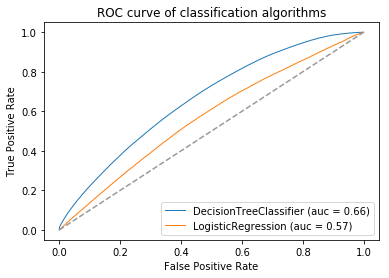

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

clfs=[DecisionTreeClassifier(max_depth=10), # Change the value of max_depth to see overfit on train
            #RandomForestClassifier(n_estimators=100),
            LogisticRegression(solver='lbfgs'),
            #MultinomialNB(),
            #BernoulliNB(),
            #GaussianNB()
     ]
# using kfold cross validation compare techniques
# using a single test/train split, show ROC curve for each
for clf in clfs:
    nm = clf.__class__.__name__
    result = clf.fit(X, y)         # should fit on TRAIN here
    yp = clf.predict_proba(X)[:,1] # now predict on TEST here
    fpr, tpr, _ = roc_curve(y, yp) # 
    roc_auc = auc(fpr, tpr)
    label='%s (auc = %0.2f)' % (nm,roc_auc)
    print(label)
    plt.plot(fpr, tpr, lw=1, label=label)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of classification algorithms')
    plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.show()

In [21]:
dtree = DecisionTreeClassifier(max_depth=2)

In [22]:
dfboth.gender_lbl.value_counts()


F    149627
M    118235
U     11634
Name: gender_lbl, dtype: int64

In [23]:
#list(dfboth)
dtree.fit(X,y)
yhat = dtree.predict(X)
pd.crosstab(y,yhat)

col_0,False
party_lbl,
False,204583
True,74913


In [24]:
! pip install pydot

In [25]:
! pip install pydotplus

In [26]:
from sklearn import tree, model_selection
dtree = tree.DecisionTreeClassifier(max_depth=5)
dtree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
! pip install graphviz

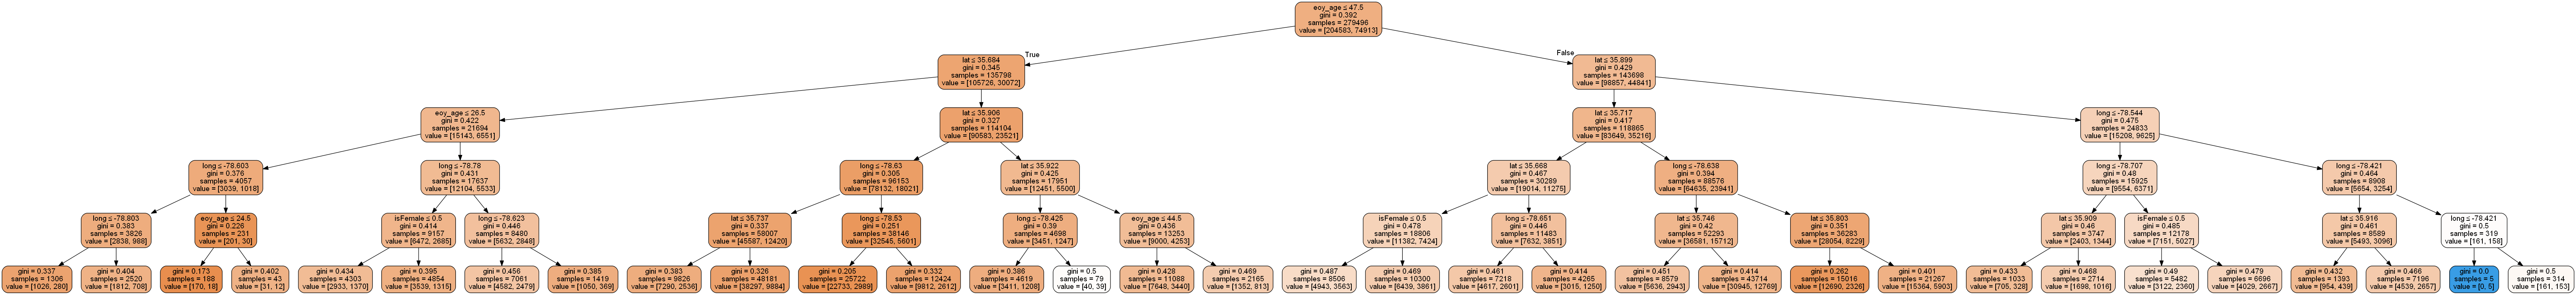

In [28]:
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot
import pydotplus 
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                filled=True, rounded=True,
                feature_names=list(X),
                special_characters=True)
graph_1 = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph_1.create_png())

### Import Datafile into Python and Describe all the features (include string variables): Add Markdown to explain your results 
### Preprocess the Features, Removing irrelevant features and outliers
### Examine the relationships between Features using Scatter Plots and Cross Tabs
### Select and Describe the Outcome Variable Y
### Select and Describe the Features being used to Predict Y
### Split the data into Train and Test (70/30), and apply three classification models to the data
### Examine Model Performance: Show Confusion Matrics, ROCs. Compute AUC. Explain your result

## Your personal extras

### you have half a dozen votes, what do you think will happen next time with small sample?

### what about your street, is there a rep/dem/una tendency? explain

### will they vote? why?

### what is the trend in voting participation by voting label? why do you think this is

### could you classify anything other than likelihood to vote?

### ramifications of density (voters per unit of area)?

In [50]:
import pandas as pd
import numpy as np
from builtins import print
from sklearn import tree, model_selection
from math import log, isnan
classifiers = [LogisticRegression(solver='lbfgs'),
               DecisionTreeClassifier(max_depth=10),
            RandomForestClassifier(n_estimators=100),
            MultinomialNB(),
            BernoulliNB(),
            GaussianNB()]
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib
import matplotlib.pyplot as plt

In [51]:
df = pd.concat([vrdb01,vrdb02_12,vrdb13_20])
df.head()

,county_name,ReportDate,voter_reg_num,status_lbl,last_name,first_name,middle_name,name_suffix_lbl,house_num,half_code,...,11/04/2014,10/06/2015,11/03/2015,03/15/2016,06/07/2016,11/08/2016,10/10/2017,11/07/2017,05/08/2018,11/06/2018
0,WAKE,2019-04-08,100454856,I,ATKINSON,ERIC,H,NaN,2720,NaN,...,NaN,NaN,NaN,V,NaN,NaN,NaN,NaN,NaN,NaN
1,WAKE,2019-04-08,100621112,A,ATLI,AYSEL,NaN,NaN,613,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
2,WAKE,2019-04-08,31092191,A,ATTRIDE,THOMAS,JAY,NaN,2400,NaN,...,V,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN,V
3,WAKE,2019-04-08,100544923,A,AUTEN,EMMA,MADELINE,NaN,101,NaN,...,NaN,NaN,NaN,NaN,NaN,O,NaN,NaN,NaN,V
4,WAKE,2019-04-08,100392346,A,AUTRY,BREANNA,DELORES,NaN,822,NaN,...,V,NaN,NaN,O,NaN,O,NaN,P,NaN,O


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712489 entries, 0 to 293813
Data columns (total 63 columns):
county_name                   712489 non-null object
ReportDate                    712489 non-null datetime64[ns]
voter_reg_num                 712489 non-null int64
status_lbl                    712489 non-null object
last_name                     712480 non-null object
first_name                    712486 non-null object
middle_name                   654857 non-null object
name_suffix_lbl               36282 non-null object
house_num                     712489 non-null int64
half_code                     352 non-null object
street_dir_lbl                26957 non-null object
street_name                   712489 non-null object
street_type_lbl               706549 non-null object
street_suffix_lbl             1289 non-null object
unit_designator               0 non-null float64
unit_num_str                  98805 non-null object
city                          712489 non-null o

In [54]:
df1=df.fillna(0)
df1.head()

,county_name,ReportDate,voter_reg_num,status_lbl,last_name,first_name,middle_name,name_suffix_lbl,house_num,half_code,...,11/04/2014,10/06/2015,11/03/2015,03/15/2016,06/07/2016,11/08/2016,10/10/2017,11/07/2017,05/08/2018,11/06/2018
0,WAKE,2019-04-08,100454856,I,ATKINSON,ERIC,H,0,2720,0,...,0,0,0,V,0,0,0,0,0,0
1,WAKE,2019-04-08,100621112,A,ATLI,AYSEL,0,0,613,0,...,0,0,0,0,0,0,0,0,0,V
2,WAKE,2019-04-08,31092191,A,ATTRIDE,THOMAS,JAY,0,2400,0,...,V,0,0,0,0,V,0,0,0,V
3,WAKE,2019-04-08,100544923,A,AUTEN,EMMA,MADELINE,0,101,0,...,0,0,0,0,0,O,0,0,0,V
4,WAKE,2019-04-08,100392346,A,AUTRY,BREANNA,DELORES,0,822,0,...,V,0,0,O,0,O,0,P,0,O


In [55]:
df['nonvoter11/04/2014'] = np.where(df['11/04/2014']==0,0,2)
df['nonvoter10/06/2015'] = np.where(df['10/06/2015']==0,0,2)
df['nonvoter03/15/2016'] = np.where(df['03/15/2016']==0,0,2)
df['nonvoter06/07/2016'] = np.where(df['06/07/2016']==0,0,2)
df['nonvoter11/08/2016'] = np.where(df['11/08/2016']==0,0,2)
df['nonvoter10/10/2017'] = np.where(df['10/10/2017']==0,0,2)
df['nonvoter11/07/2017'] = np.where(df['11/07/2017']==0,0,2)
df['nonvoter05/08/2018'] = np.where(df['05/08/2018']==0,0,2)
df['nonvoter11/06/2018'] = np.where(df['11/06/2018']==0,0,2)
df['name_suffix_lbl'] = np.where(df['name_suffix_lbl']==0,0,2)
df['half_code'] = np.where(df['half_code']==0,0,2)
df['middle_name'] = np.where(df['middle_name']==0,0,2)
df['11/06/2018'] = np.where(df['11/06/2018']==0,0,2)
df.head()

,county_name,ReportDate,voter_reg_num,status_lbl,last_name,first_name,middle_name,name_suffix_lbl,house_num,half_code,...,11/06/2018,nonvoter11/04/2014,nonvoter10/06/2015,nonvoter03/15/2016,nonvoter06/07/2016,nonvoter11/08/2016,nonvoter10/10/2017,nonvoter11/07/2017,nonvoter05/08/2018,nonvoter11/06/2018
0,WAKE,2019-04-08,100454856,I,ATKINSON,ERIC,2,2,2720,2,...,2,2,2,2,2,2,2,2,2,2
1,WAKE,2019-04-08,100621112,A,ATLI,AYSEL,2,2,613,2,...,2,2,2,2,2,2,2,2,2,2
2,WAKE,2019-04-08,31092191,A,ATTRIDE,THOMAS,2,2,2400,2,...,2,2,2,2,2,2,2,2,2,2
3,WAKE,2019-04-08,100544923,A,AUTEN,EMMA,2,2,101,2,...,2,2,2,2,2,2,2,2,2,2
4,WAKE,2019-04-08,100392346,A,AUTRY,BREANNA,2,2,822,2,...,2,2,2,2,2,2,2,2,2,2


In [56]:
df1 = df.copy(deep=True)
df1=df[['gender_lbl', 'race_lbl', 'house_num', '11/06/2018', 'voter_reg_num']]

In [57]:
df1.head

<bound method NDFrame.head of        gender_lbl race_lbl  house_num  11/06/2018  voter_reg_num
0               M        W       2720           2      100454856
1               F        W        613           2      100621112
2               M        W       2400           2       31092191
3               F        U        101           2      100544923
4               F        M        822           2      100392346
5               F        W        401           2      100390426
6               F        B       2311           2      100202068
7               F        U        606           2      100240855
8               M        U       2501           2      100647284
9               F        O        401           2      100511454
10              F        W       2402           2      100377719
11              U        U        206           2      100494074
12              F        U        119           2      100646573
13              M        W       2715           2      10033

In [58]:
import numpy as np
meanhouse_num=np.mean(df.house_num)
df.house_num = df.house_num.fillna(meanhouse_num)

AttributeError: Unknown property column

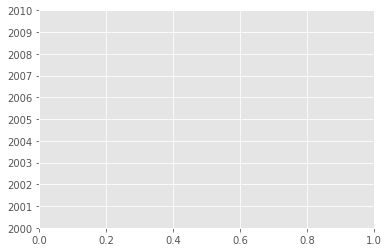

In [42]:
df.plot(column='voter_reg_num', by = 'house_num')

In [59]:
from sklearn import model_selection
df2 = df1.copy(deep=True)
X = df2.drop(['race_lbl', 'gender_lbl'],axis=1)
y = df2['house_num']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.3,random_state=0)

In [60]:
print(list(X))

['house_num', '11/06/2018', 'voter_reg_num']


In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()

In [62]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [64]:
ypredict=knn.predict(X_test)
print(metrics.confusion_matrix(y_test, ypredict))

[[796   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  3   0   1 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [1]:
from sklearn import tree, model_selection
dtree = tree.DecisionTreeClassifier(max_depth=5)
dtree.fit(X,y)

NameError: name 'X' is not defined

In [ ]:
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot
import pydotplus 
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                filled=True, rounded=True,
                feature_names=list(X),
                special_characters=True)
graph_1 = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph_1.create_png())